In [1]:
#Import Packages and other functions necessary for all of this to work

#import sys
#sys.path.insert(0, 'F:/Python/Defect/')
# Other Useful General Functions: 
# getcolormap, baseline, getMW, ABSORB, Test_GMM_Clusters
#from generalfunctions import getstats, get_PL_Raman_Current_Voltage_From_Matlab_File, Test_GMM_Clusters
#from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.mlab as mlab
import numpy as np

#used to take the derivative of noisy data
from scipy.interpolate import UnivariateSpline

#used to do fitting
from scipy.optimize import leastsq

#used for image segmentation and watershedding
from skimage import data, feature, filters
from skimage.filters import rank
from scipy import ndimage as ndi
from skimage.morphology import watershed, disk

# import clustering algorithms, distance calculations
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.decomposition import PCA

#set the useful functions to be used here:
def normalize_spectra_to_1(SPECTRA):
    #takes a matrix N x k where N is the number of observations and k is the number of variables(colums) and normalizes
    #each observation (row) to the maxiumum of all variables (colums)
    max_Spectra = np.ones((SPECTRA.shape[1],1)).dot(np.max(SPECTRA,axis=1)*np.ones((1,SPECTRA.shape[0]))).T
    SPECTRA/= max_Spectra
    return SPECTRA

def scale_spectra_0_1(SPECTRA):
    #takes a matrix N x k where N is the number of observations and k is the number of variables(colums) and scales
    #each observation (row) to range from 0 to 1
    max_Spectra = np.ones((SPECTRA.shape[1],1)).dot(np.max(SPECTRA,axis=1)*np.ones((1,SPECTRA.shape[0]))).T
    min_Spectra = np.ones((SPECTRA.shape[1],1)).dot(np.min(SPECTRA,axis=1)*np.ones((1,SPECTRA.shape[0]))).T
    return (SPECTRA-min_Spectra)/(max_Spectra-min_Spectra)

def lorentzian(x,p):
    #p = [width, center, amplitude]
    numerator =  (p[0]**2 )
    denominator = ( x - (p[1]) )**2 + p[0]**2
    y = p[2]*(numerator/denominator)
    return y

def errorfunc(p,x,z):
        return lorentzian(x,p)-z
    
def get_PL_Raman_Current_Voltage_From_Matlab_File(fpath):
    import scipy.io
    data = scipy.io.loadmat(fpath, mat_dtype=1) #mat_dtype=1 ensures that vars are imported as arrays
    #print data.keys()
    
    # the string in the brackets references the matlab data file name
    # the data is imported into python as a dictionary and this is how you reference the values
    
    x_coord_array = data['X'] # variable holding the x corrdinates
    y_coord_array = data['Y'] # variable holding the y coordinates

    PL = data["PL"]
    RAMAN = data["RAMAN"]

    wavenumber = data["wavenumber"]
    wavelength = data["wavelength"]

    wn = wavenumber.ravel() # data are imported as N x 1 matricies which complicates plotting later
    wl = wavelength.ravel() # ravel() removes the second dimension so it is an array of length N

    current = data["CURRENT"]
    voltage = data["VOLTAGE"]

    # calculates the step size based on the maximum difference in x and y dirrection to 3 decimal places
    x_step_size = round(np.diff(x_coord_array,axis=0).max(),3) 
    y_step_size = round(np.diff(y_coord_array,axis=0).max(),3) 

    #identifies the number of pixels in both the x and y directions
    x_pixels = int((x_coord_array.max() - x_coord_array.min())/x_step_size + 1)
    y_pixels = int((y_coord_array.max() - y_coord_array.min())/y_step_size + 1)
    
    #converts the number of pixels to a distance in microns based on the stepsize
    x = (np.arange(x_pixels)-x_pixels/2)*x_step_size
    y = (np.arange(y_pixels)-y_pixels/2)*y_step_size

    #send the data back to the user
    return data,PL,RAMAN,wl,wn,current,voltage,x,y,x_pixels,y_pixels    

def baseline(y, deg=None, max_it=None, tol=None):
    """
    Computes the baseline of a given data.

    Iteratively performs a polynomial fitting in the data to detect its
    baseline. At every iteration, the fitting weights on the regions with
    peaks are reduced to identify the baseline only.

    Parameters
    ----------
    y : ndarray
        Data to detect the baseline.
    deg : int (default: 3)
        Degree of the polynomial that will estimate the data baseline. A low
        degree may fail to detect all the baseline present, while a high
        degree may make the data too oscillatory, especially at the edges.
    max_it : int (default: 100)
        Maximum number of iterations to perform.
    tol : float (default: 1e-3)
        Tolerance to use when comparing the difference between the current
        fit coefficients and the ones from the last iteration. The iteration
    procedure will stop when the difference between them is lower than
    *tol*.

    Returns
    -------
    ndarray
    Array with the baseline amplitude for every original point in *y*
    """
    import math
    import scipy.linalg as LA


    # for not repeating ourselves in `envelope`
    if deg is None: deg = 3
    if max_it is None: max_it = 100
    if tol is None: tol = 1e-3

    order = deg + 1
    coeffs = np.ones(order)

    # try to avoid numerical issues
    cond = math.pow(y.max(), 1. / order)
    x = np.linspace(0., cond, y.size)
    base = y.copy()

    vander = np.vander(x, order)
    vander_pinv = LA.pinv2(vander)

    for _ in range(max_it):
        coeffs_new = np.dot(vander_pinv, y)

        if LA.norm(coeffs_new - coeffs) / LA.norm(coeffs) < tol:
            break

        coeffs = coeffs_new
        base = np.dot(vander, coeffs)
        y = np.minimum(y, base)

    return base

    def envelope(y, deg=None, max_it=None, tol=None):
        """
        Computes the upper envelope of a given data.
        It is implemented in terms of the `baseline` function.

        Parameters
        ----------
        y : ndarray
                Data to detect the baseline.
        deg : int
                Degree of the polynomial that will estimate the envelope.
        max_it : int
                Maximum number of iterations to perform.
        tol : float
                Tolerance to use when comparing the difference between the current
                fit coefficients and the ones from the last iteration.

        Returns
        -------
        ndarray
                Array with the envelope amplitude for every original point in *y*
        """
        return y.max() - baseline(y.max() - y, deg, max_it, tol)


['RAMAN', 'VOLTAGE_pl', 'wavenumber', '__header__', '__globals__', 'CURRENT', 'VOLTAGE', 'wavelength', 'Y', 'X', '__version__', 'PL']


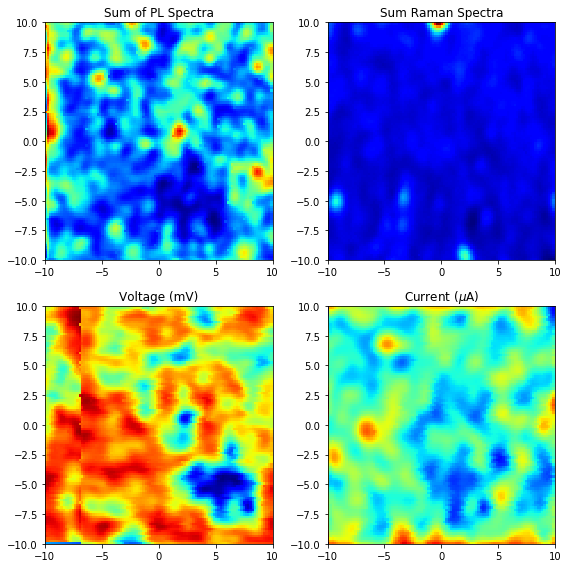

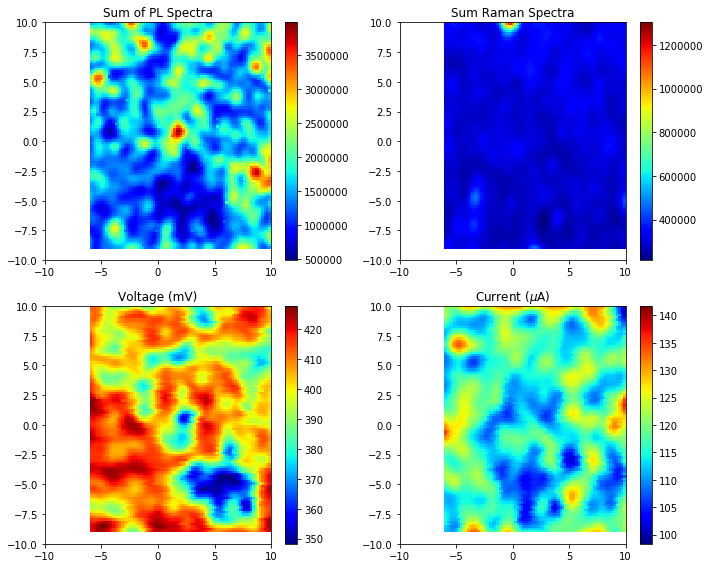

In [2]:
#Load the Spectrum Files and Electrical Data from a Pre-processed matlab file 
file_path_to_renishaw_data = 'AIST_slg.mat'

#use parenthesis to break long lines of code over multiple lines
(dictionary_of_matlab_variables, 
 pl_spectra, raman_spectra, 
 pl_energy_wavelength, raman_energy_wavenumber, 
 current_amps, voltage_volts, 
 x_distance_um, y_distance_um, 
 number_of_x_pixels, number_of_y_pixels) = get_PL_Raman_Current_Voltage_From_Matlab_File(file_path_to_renishaw_data)

print dictionary_of_matlab_variables.keys() #show the names of variables stored in matlab file inorder to extract them

##### uncomment to use voltage from a different run on same sample
if file_path_to_renishaw_data == 'AIST_slg.mat' or file_path_to_renishaw_data == 'AIST_slg_naf.mat':
    voltage_volts = dictionary_of_matlab_variables["VOLTAGE_pl"] 

#create a map of the x and y coordinates by using meshgrid
x_position_map, y_position_map = np.meshgrid(x_distance_um, y_distance_um)

# spectra data has the shape [number_of_pixels, bins_in_energy_space]
#sum the spectra to find total intensity: (axis=1) means you sum across all energies
# summed_***_spectra now has shape  [number_of_pixels,]
summed_raman_spectra = np.sum(raman_spectra, axis=1)
summed_pl_spectra = np.sum(pl_spectra, axis=1)

#reshape the summed_spectra to be:
# [number_of_x_pixels, number_of_y_pixels]
summed_pl_spectra_matrix = np.reshape(summed_pl_spectra, (number_of_x_pixels, number_of_y_pixels))
summed_raman_spectra_matrix = np.reshape(summed_raman_spectra, (number_of_x_pixels, number_of_y_pixels))
current_map_uA = np.reshape(current_amps*1E6, (number_of_x_pixels, number_of_y_pixels))
voltage_map_mV = np.reshape(voltage_volts*1E3, (number_of_x_pixels, number_of_y_pixels))

#Visualize the Data
f,ax = plt.subplots(2,2,figsize=(8,8))
ax[0,0].pcolor(x_position_map, y_position_map, summed_pl_spectra_matrix, cmap='jet')
ax[0,0].set_title('Sum of PL Spectra')
ax[0,1].pcolor(x_position_map, y_position_map, summed_raman_spectra_matrix, cmap='jet')
ax[0,1].set_title('Sum Raman Spectra')
ax[1,1].pcolor(x_position_map, y_position_map, current_map_uA, cmap='jet')
ax[1,1].set_title('Current ($\mu$A)')
ax[1,0].pcolor(x_position_map, y_position_map, voltage_map_mV, cmap='jet')
ax[1,0].set_title('Voltage (mV)')
plt.tight_layout()

'''
Apply mask to remove parts of the map where something went wrong
'''

# set trim_the_data to 0 if you do not want to apply a mask to the data
# trim_map intitalizes the regions to be masked 
trim_the_data = 1
trim_map = np.zeros((number_of_x_pixels,number_of_y_pixels))

if trim_the_data == 1:
    #set the position to trim the x and y data arrays
    if file_path_to_renishaw_data == 'AIST_slg.mat':
        x_trim, y_trim = x_distance_um >= -6, y_distance_um >= -9 #slg
    elif file_path_to_renishaw_data == 'AIST_slg_naf.mat':
        x_trim, y_trim = x_distance_um >= -9, y_distance_um >= -9 #slg_naf
    elif  file_path_to_renishaw_data == 'AIST_saph.mat':
        x_trim, y_trim = x_distance_um >= -9, y_distance_um >= -7.5 #saph
    elif  file_path_to_renishaw_data == 'AIST_saph_naf.mat':
        x_trim, y_trim = x_distance_um >= -9, y_distance_um >= -9 #saph
    else:
        x_trim, y_trim = min(x_distance_um), min(y_distance_um)
    
    #combine them into a trim map and trim_array of 0s, and 1s, of length number_of_total_pixels
    x_trim_map, y_trim_map = np.meshgrid(x_trim, y_trim)
    trim_map[(x_trim_map == 1) & (y_trim_map == 1)] = 1
    trim_array = trim_map.ravel()
    #trim_map = np.reshape(trim_array, (number_of_x_pixels, number_of_y_pixels))

#set up new arrays that can allow for masked values
masked_maps = []
data = [summed_pl_spectra_matrix, summed_raman_spectra_matrix, voltage_map_mV, current_map_uA]
for i in data:
    masked_maps.append(np.ma.array(i))
for i in masked_maps:
    i[trim_map == 0] = np.ma.masked
masked_spectra = []
spectra = [pl_spectra,raman_spectra]
for i in spectra:
    masked_spectra.append(np.ma.array(i))
for i in masked_spectra:
    i[trim_array == 0,:] = np.ma.masked
masked_pl_spectra = masked_spectra[0]
masked_raman_spectra = masked_spectra[1]    
#Visualize the Data
f,axes = plt.subplots(2,2,figsize=(10,8))
ax = axes.ravel() #converts 2x2 axis object to an array (row-wise)
plot_titles =['Sum of PL Spectra','Sum Raman Spectra','Voltage (mV)','Current ($\mu$A)']

# include the following line to do a log_scale colorbar:
#norm=colors.LogNorm(vmin=np.min(z), vmax= np.max(z))

for idx, (z,tit) in enumerate(zip(masked_maps,plot_titles)):
    pcm = ax[idx].pcolor(x_position_map, y_position_map, z, vmin = np.min(z), vmax = np.max(z), cmap='jet')
    ax[idx].set_title(tit)
    f.colorbar(pcm, ax = ax[idx])

plt.tight_layout()

plt.show()

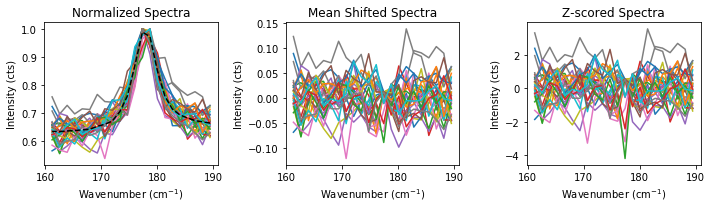

In [3]:
'''
Look at Raman Spectra
'''
#normalize the data by the maximum of each pl spectrum
a1_mode = (raman_energy_wavenumber > 160) & (raman_energy_wavenumber < 190)
cds_mode = (raman_energy_wavenumber > 225) & (raman_energy_wavenumber < 340)
hump_mode = (raman_energy_wavenumber > 100) & (raman_energy_wavenumber < 160)
all_wn = [True]*len(raman_energy_wavenumber)
normalize_mode = a1_mode
selected_mode = a1_mode


SPECTRA = masked_raman_spectra
max_Spectra = np.ones((SPECTRA.shape[1],1)).dot(np.max(SPECTRA[:,normalize_mode],axis=1)*np.ones((1,SPECTRA.shape[0]))).T


features = SPECTRA/max_Spectra

# subtract the average pl spectrum from every spectra such that mean(pl_spectra[:,Energy]) = 0
mfeatures = (features -np.mean(features, axis=0)) 

# set the standard deviation of each energy bin to 1
zfeatures = (features -np.mean(features, axis=0))/np.std(features,axis=0)



#plot every INTERVAL of pixels
interval = 250
Energy = raman_energy_wavenumber[selected_mode]

fig, ax = plt.subplots(1,3,figsize=(10,3))
ax[0].plot(Energy.T,features[::interval,selected_mode].T,Energy.T,np.mean(features,axis=0)[selected_mode],'--k') # need to transpose because the first dimension needs to be the same 
ax[1].plot(Energy.T,mfeatures[::interval,selected_mode].T)
#ax[1].plot([1060,1060],[-0.2,0.15],'--k')
#ax[1].plot([1130,1130],[-0.2,0.15],'--k')
ax[2].plot(Energy.T,zfeatures[::interval,selected_mode].T)

title = ['Normalized Spectra','Mean Shifted Spectra','Z-scored Spectra']
for counter,a in enumerate(ax):
    a.set_title(title[counter])
    a.set_xlabel('Wavenumber (cm$^{-1}$)')
    a.set_ylabel('Intensity (cts)')
    if counter == 3:
        a.set_xlabel('Distance in $\mu$m')
        a.set_ylabel('Distance in $\mu$m')
plt.tight_layout()

plt.show()

	FWHM 	 Center 	 Amplitude
[   2.7128602   177.57329042    0.39111599]


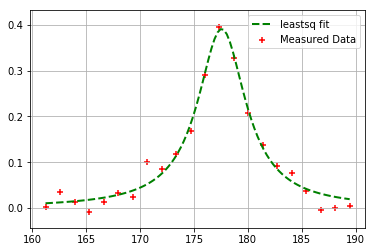

In [4]:
'''
Fit Raman A1 Mode With Lorenzian
'''
#a1_mode = (raman_energy_wavenumber > 160) & (raman_energy_wavenumber < 190)
selected_mode = a1_mode
mode_spectra = features[:,selected_mode]
mode_energy_wavenumber= raman_energy_wavenumber[selected_mode]

x = mode_energy_wavenumber
y = mode_spectra[5111,:] 
y -= baseline(y,1)
X = np.linspace(min(x),max(x),100)
p0 = np.array([1., 175., 1.], dtype=np.double) #Initial guess
solp, ier = leastsq(errorfunc, 
                    p0, 
                    args=(x,y),
                    Dfun=None,
                    full_output=False,
                    ftol=1e-9,
                    xtol=1e-9,
                    maxfev=100000,
                    epsfcn=1e-10,
                    factor=0.1)
solp= np.abs(solp)
print '\tFWHM \t Center \t Amplitude'
print solp

plt.scatter(x, y, c='r', marker='+', label='Measured Data')
plt.plot(X, lorentzian(X,solp), 'g--', linewidth=2, label='leastsq fit')

plt.grid(which='both')
plt.legend()
plt.show()

In [5]:
'''
Loop through all pixels and fit the A1 mode for each and pull out the center, FWHM and AMPLITUDE
'''

from time import time
t0 = time()
mode_FWHM = np.ma.zeros((mode_spectra.shape[0],1)).ravel()
mode_CENTER = np.ma.zeros((mode_spectra.shape[0],1)).ravel()
mode_PEAK = np.ma.zeros((mode_spectra.shape[0],1)).ravel()

for i in range(mode_spectra.shape[0]):
    if i % 500 == 0:
        print i, 'of ', mode_spectra.shape[0]
    x = mode_energy_wavenumber
    y = mode_spectra[i,:]
    if all(y.mask) == True:
        continue
    y -= baseline(y,1)
    p0 = np.array([1., 175., 1.], dtype=np.double) #Initial guess
    solp, ier = leastsq(errorfunc, 
                        p0, 
                        args=(x,y),
                        Dfun=None,
                        full_output=False,
                        ftol=1e-9,
                        xtol=1e-9,
                        maxfev=100000,
                        epsfcn=1e-10,
                        factor=0.1)
    solp = np.abs(solp)
    mode_FWHM[i] = solp[0]
    mode_CENTER[i] = solp[1]
    mode_PEAK[i] = solp[2]
print 'Total time for ', i, ' least squares fits = ', round(time()-t0,2),' sec'
mode_CENTER[mode_CENTER==0] = np.ma.masked
mode_FWHM[mode_FWHM==0] = np.ma.masked
mode_PEAK[mode_PEAK==0] = np.ma.masked

0 of  10201
500 of  10201
1000 of  10201
1500 of  10201
2000 of  10201
2500 of  10201
3000 of  10201
3500 of  10201
4000 of  10201
4500 of  10201
5000 of  10201
5500 of  10201
6000 of  10201
6500 of  10201
7000 of  10201
7500 of  10201
8000 of  10201
8500 of  10201
9000 of  10201
9500 of  10201
10000 of  10201
Total time for  10200  least squares fits =  95.88  sec


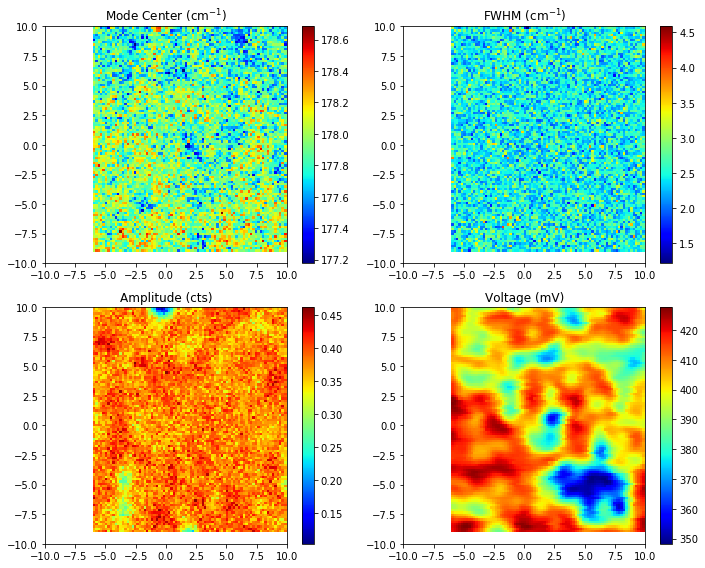

In [6]:
'''
Visualize the Raman Data with Voltage

'''
mode_CENTER_map = np.reshape(mode_CENTER, (number_of_x_pixels, number_of_y_pixels))
mode_FWHM_map = np.reshape(mode_FWHM, (number_of_x_pixels, number_of_y_pixels))
mode_PEAK_map = np.reshape(mode_PEAK, (number_of_x_pixels, number_of_y_pixels))

plot_data = [mode_CENTER_map, mode_FWHM_map, mode_PEAK_map, masked_maps[-2]]
plot_titles =['Mode Center (cm$^{-1}$)','FWHM (cm$^{-1}$)','Amplitude (cts)','Voltage (mV)']


f,axes = plt.subplots(2,2,figsize=(10,8))
ax = axes.ravel() #converts 2x2 axis object to an array (row-wise)

# include the following line to do a log_scale colorbar:
#norm=colors.LogNorm(vmin=np.min(z), vmax= np.max(z))


for idx, (z,tit) in enumerate(zip(plot_data,plot_titles)):
    pcm = ax[idx].pcolor(x_position_map, y_position_map, z, vmin = np.min(z), vmax = np.max(z), cmap='jet')
    ax[idx].set_title(tit)
    f.colorbar(pcm, ax = ax[idx])

plt.tight_layout()

plt.show()

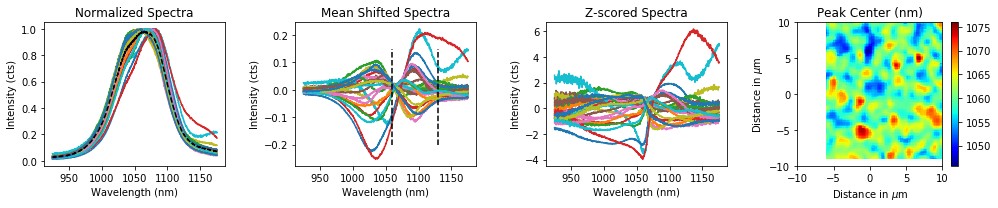

In [7]:
'''
Calculate the center peak position from the 
normalized cumulative sum of the spectra 
cumsum of a gaussian distribution is similar to a pdf
'''

sum_spec = np.cumsum(masked_pl_spectra,axis=1) # calulates the cumulative sum across each row
SPECTRA = normalize_spectra_to_1(sum_spec)

#where the normalized cumulative sum == 0.5 is the center of the distrubiton
#subtracting 0.5 from the data and taking the absolute value means that values near 0.5 will be close to zero
#taking the minimum of this will give you the center position
find_center_index = np.argmin(np.abs(SPECTRA-0.5),axis=1) 

#generate an empty array to store the energy center values 
peak_centers = np.ma.empty((SPECTRA.shape[0],1))
for i in range(SPECTRA.shape[0]):
    peak_centers[i] = pl_energy_wavelength[find_center_index[i]]

#mask the values that are undesireable
peak_centers[trim_array==0] = np.ma.masked

#reshape the array to be vsiualized as a map in X,Y coordinates 
peak_center_matrix = np.reshape(peak_centers,(number_of_x_pixels,number_of_x_pixels))

'''
Normalize all PL spectra to 1
Visualize the deviations from the mean (set mean of the data == 0)
Visualize zscored PL spectra, force the standard deviation to be 1
'''

#normalize the data by the maximum of each pl spectrum
features = normalize_spectra_to_1(masked_pl_spectra)

# subtract the average pl spectrum from every spectra such that mean(pl_spectra[:,Energy]) = 0
mfeatures = (features -np.mean(features, axis=0)) 

# set the standard deviation of each energy bin to 1
zfeatures = (features -np.mean(features, axis=0))/np.std(features,axis=0)

#plot every INTERVAL of pixels
interval = 333
Energy = pl_energy_wavelength

fig, ax = plt.subplots(1,4,figsize=(14,3))
ax[0].plot(Energy.T,features[::interval,:].T,Energy.T,np.mean(features,axis=0),'--k') # need to transpose because the first dimension needs to be the same 
ax[1].plot(Energy.T,mfeatures[::interval,:].T)
ax[1].plot([1060,1060],[-0.2,0.15],'--k')
ax[1].plot([1130,1130],[-0.2,0.15],'--k')
ax[2].plot(Energy.T,zfeatures[::interval,:].T)
pcm = ax[3].pcolor(x_distance_um,y_distance_um,peak_center_matrix,cmap='jet')
fig.colorbar(pcm,ax = ax[3])

title = ['Normalized Spectra','Mean Shifted Spectra','Z-scored Spectra','Peak Center (nm)']
for counter,a in enumerate(ax):
    a.set_title(title[counter])
    a.set_xlabel('Wavelength (nm)')
    a.set_ylabel('Intensity (cts)')
    if counter == 3:
        a.set_xlabel('Distance in $\mu$m')
        a.set_ylabel('Distance in $\mu$m')
plt.tight_layout()
plt.show()

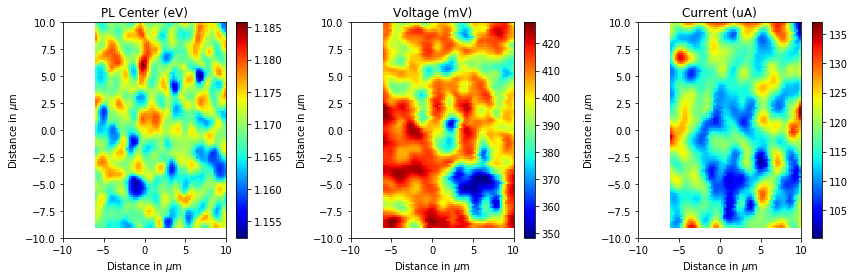

In [8]:
'''
Plot the voltage and peak center maps side by side
'''
f,axes = plt.subplots(1,3,figsize=(12,4))
ax = axes.ravel()
data = [1240/peak_center_matrix,masked_maps[-2],masked_maps[-1]]
title = ['PL Center (eV)','Voltage (mV)','Current (uA)']
for idx in range(len(ax)):
    pcm = ax[idx].pcolor(x_distance_um,y_distance_um,data[idx],cmap='jet')
    ax[idx].set_title(title[idx])
    ax[idx].set_xlabel('Distance in $\mu$m')
    ax[idx].set_ylabel('Distance in $\mu$m')         
    f.colorbar(pcm,ax = ax[idx])
plt.tight_layout()
plt.show()


In [9]:
#fwhm
def FWHM(X,Y):
    half_max = max(Y) / 2.
    max_idx = np.argmax(Y)
    left_idx = np.argmin(np.abs(Y[0:max_idx]-half_max))
    right_idx = np.argmin(np.abs(Y[max_idx::]-half_max))+ max_idx
    return X[right_idx] - X[left_idx] #return the difference (full width)
    #explains what is happening above 
#     print X, Y # read in the X and Y values
#     print max(Y) / 2. #get the half max value
#     half_max = max(Y) / 2.
#     print np.argmax(Y) # find the index of the maximum Y value

#     print Y[np.argmax(Y)] #print out the maximum at that index to make sure it  makes sense
#     print np.argmin(np.abs(Y[0:np.argmax(Y)]-max(Y) / 2.)) # look at the first half of the data and find where it switches from - to +
#     left_idx = np.argmin(np.abs(Y[0:np.argmax(Y)]-max(Y) / 2.))
#     print Y[left_idx] #check the value to make sure
#     print np.argmin(np.abs(Y[np.argmax(Y)::]-0.5))+ np.argmax(Y) #find the value on the right side of the curve
#     right_idx = np.argmin(np.abs(Y[np.argmax(Y)::]-0.5))+ np.argmax(Y)
#     print Y[right_idx] #check the value to make sure its clsoe to half max
#     print X[right_idx]-X[left_idx] #subtract the two values 



t0 = time()
pl_FWHM = np.ma.zeros((pl_spectra.shape[0],1)).ravel()
for i in range(len(pl_FWHM)):
    if i % 500 == 0:
        print i, 'of ', len(pl_FWHM)
    Y = masked_pl_spectra[i,:]
    if all(Y.mask) == True:
        continue
    X = pl_energy_wavelength
    pl_FWHM[i] = FWHM(X,Y)
print 'The time to find the PL FWHM for ', i ,' pixels is ', round(time()-t0,2), 'seconds'
pl_FWHM[pl_FWHM == 0] = np.ma.masked
pl_FWHM_map = np.reshape(pl_FWHM,(number_of_x_pixels,number_of_x_pixels))


0 of  10201
500 of  10201
1000 of  10201
1500 of  10201
2000 of  10201
2500 of  10201
3000 of  10201
3500 of  10201
4000 of  10201
4500 of  10201
5000 of  10201
5500 of  10201
6000 of  10201
6500 of  10201
7000 of  10201
7500 of  10201
8000 of  10201
8500 of  10201
9000 of  10201
9500 of  10201
10000 of  10201
The time to find the PL FWHM for  10200  pixels is  27.82 seconds


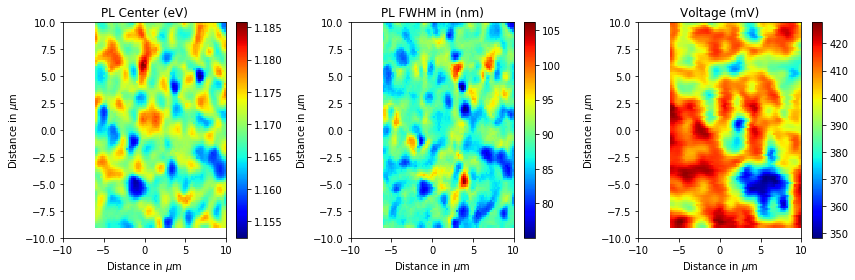

In [10]:
'''
Plot the voltage and peak center maps side by side
'''
f,axes = plt.subplots(1,3,figsize=(12,4))
ax = axes.ravel()
data = [1240/peak_center_matrix, pl_FWHM_map, masked_maps[-2]]
title = ['PL Center (eV)','PL FWHM in (nm)','Voltage (mV)']
for idx in range(len(ax)):
    pcm = ax[idx].pcolor(x_distance_um,y_distance_um,data[idx],cmap='jet')
    ax[idx].set_title(title[idx])
    ax[idx].set_xlabel('Distance in $\mu$m')
    ax[idx].set_ylabel('Distance in $\mu$m')         
    f.colorbar(pcm,ax = ax[idx])
plt.tight_layout()
plt.show()

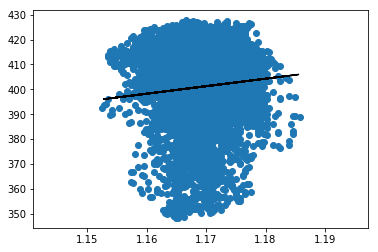

In [11]:
x = 1240/peak_center_matrix.compressed()#[::10]
y = masked_maps[-2].compressed()#[::10]
fit = np.polyfit(x,y,1)
fit_fn = np.poly1d(fit)
plt.scatter(x,y)
plt.plot(x,fit_fn(x),'--k')
plt.show()

In [ ]:
'''
 Calculates the slope dV/d(counts) at a fixed wavelength
 
 This tells us about how different radiative recombination pathways affect the voltage
 positive slope means more recombination along that path enhances quasi fermi level splitting
 negative slope means more recombination along that path reduces quasi fermi level splitting?
'''

if file_path_to_renishaw_data == 'AIST_slg_naf.mat':
    s = 0.3 #sensitivity of the spline to noisy data (smaller number means it is more sensitive to changes in data )
    eps = 0.1 # threshehold for the derivative of the spline to count as an inflection point
    
elif file_path_to_renishaw_data == 'AIST_slg.mat':
    s = 0.3 #sensitivity of the spline to noisy data (smaller number means it is more sensitive to changes in data )
    eps = 0.03 # threshehold for the derivative of the spline to count as an inflection point
elif file_path_to_renishaw_data == 'AIST_saph.mat':
    s = 0.05 #sensitivity of the spline to noisy data (smaller number means it is more sensitive to changes in data )
    eps = 0.001 # threshehold for the derivative of the spline to count as an inflection point
else:
    s = 1
    eps = 0.1

#empty variable to hold the slope between the voltage and the intensity at a given wavelength
slop = []

#define which variable to use for the x data and the energy range to look over
x_data = features
vals = range(150,len(pl_energy_wavelength))

#define the Y values for the slope calculation (ie: normalized voltage)
target = np.ma.array(voltage_volts)
target[trim_array==0] = np.ma.masked
target = target.compressed()
norm_volt = ((target - min(target))/(max(target)-min(target))).ravel()
Y=norm_volt


# for each energy bin in x_data, remove the masked values with (.compressed) and fit a line between x and y
for i in vals:
    xx = x_data[:,i].compressed()
    fit = np.polyfit(xx,Y,1) #fit a 1st order polynomial, fit = [slope, intercept]
    slop.append(fit[0]) # add the fitted slope to the slop variable

#Visualize the data
E_vals = pl_energy_wavelength[vals]
plt.scatter(E_vals,slop,s=2,label='Data')
plt.plot([min(E_vals), max(E_vals)], [0,0],'-k',label='Zero')

#fit a spline to the data
X = np.linspace(min(E_vals),max(E_vals),10000)
spl = UnivariateSpline(E_vals, slop, s=s)
dspl = spl.derivative()
ddspl = dspl.derivative()
min_max= X[np.abs(dspl(X)) < eps]


plt.plot(X, spl(X), 'r', lw=1,label='Spline')
plt.plot(X, dspl(X),'b',lw=1,label='1st Derivative')
ax = plt.gca()
#ax.set_ylim([-0.02,0.02])
#ax.set_xlim([1055,1065])
ax.set_xlabel('Energy (eV)')
ax.set_ylabel('dV/d(cts)')
ax.set_title('Spectrally Resolved Voltage Dependence')
ax.legend()


# only select values that are more than 1 nm away from each other, 
#we determine this by taking the differential of the values close to zero
#if the distance between values that are near zero is > 1 nm we keep that value and round to the nearest nm 
switches = np.round(min_max[np.diff(np.append(min_max,min_max[-1])) > 1],0) 

#switches = switches[switches < 1260]
print 'Inflection Points : ', switches, 'nm'

#switches = [1025,1055,1065,1100,1145]
I_data = [None]*len(switches)
for idx,energy in enumerate(switches):
    I_data[idx] = np.reshape(features[:,np.round(Energy,0)==energy][:,0],(number_of_x_pixels,number_of_y_pixels))

f,axes = plt.subplots(2,3,figsize=(14,8))
ax = axes.ravel()
for idx,(z,title) in enumerate(zip(I_data,switches)):
    pcm = ax[idx].pcolor(x_distance_um, y_distance_um, z, cmap='jet')#,vmin=0, vmax=1
    ax[idx].set_title("Intensity at "+str(title)+' nm')
    f.colorbar(pcm, ax=ax[idx]) #add a colorbar

plt.tight_layout()

plt.show()



In [ ]:
index_map_numerator = 1
index_map_denominator = 2
diff_map = I_data[index_map_numerator]/I_data[index_map_denominator]
f,ax = plt.subplots(1,1,figsize=(5,4))
pcm = ax.pcolor(x_distance_um,y_distance_um, diff_map, cmap= 'jet')
ax.set_xlabel('Distance in $\mu$m')
ax.set_ylabel('Distance in $\mu$m')
ax.set_title('Differential map of '+ str(switches[index_map_numerator])+'nm / '+str(switches[index_map_denominator])+'nm')
f.colorbar(pcm,ax=ax)


'''
The differential maps identifies pixels that are 
really intense above the average bandgap and intense below the average bandgap
if we set 1 (where the intensities above and below are equal) as the switch point
can show that these high energy grains have better voltage than the low energy grains
'''
low_stamp = diff_map < 1.02
high_stamp = diff_map > 0.98

diff_map[high_stamp] = np.ma.masked
f,ax = plt.subplots(1,1, figsize=(5,4))
ax.pcolor(x_distance_um,y_distance_um,diff_map,cmap='jet')

plt.tight_layout()

plt.show()

In [ ]:
'''
Compare Box plots from a differental map ... doesnt really work
'''


low_stamp = diff_map < 1.02
high_stamp = diff_map > 0.98

stamps = [[low_stamp],[high_stamp]]
titles = ['voltage','PL peak center (nm)', 'current','integrated pl intensity']
arrays_of_interest = [voltage_map_mV, peak_center_matrix, current_map_uA, summed_pl_spectra_matrix]
energy_data = [None]*len(stamps)
for stamp_idx,stamp in enumerate(stamps):
    
    index_map_numerator = 1
    index_map_denominator = 2
    
    diff_map = np.ma.array(I_data[index_map_numerator]/I_data[index_map_denominator])
    diff_map[stamp] = np.ma.masked

    diff_map[diff_map.mask] = 0.
    markers = np.zeros_like(diff_map)
    markers[diff_map == 0] = 1
    markers[diff_map > 0] = 2
    markers = ndi.binary_fill_holes(markers-1) #im not sure what this does but it gets ndi.label to work and give a unique number to each region
    labels, _ = ndi.label(markers)

    data_from_stamp = []
    for data in arrays_of_interest:
        temp = []
        for idx in range(1,np.max(labels)+1,1):
            if np.sum(labels == idx) < 15:
                continue
            temp.append(np.mean(data[labels==idx]))
        data_from_stamp.append(temp)
    
    energy_data[stamp_idx] = data_from_stamp


f,axes = plt.subplots(3,2, figsize = (6,6))
colors=['red','blue','black']
ax = axes.ravel()
for idx,(data1,data2,tit) in enumerate(zip(energy_data[0],energy_data[1],titles)):
    bp = ax[idx].boxplot([data1,data2],positions=range(2))
    #ax[idx].boxplot(data2,positions=range(1,2,1))
    ax[idx].set_title(tit)
    ax[idx].legend()

    ax[idx].tick_params(axis='both', direction='in', top='on', right='on')

    # Iterate over each of the elements changing the color
    elements = ['boxes','caps','whiskers','fliers','medians']
    for elem in elements:
        boxc = []
        num = int(np.floor(len(bp[elem])/2))
        for grp in range(2):
            boxc = boxc+[colors[grp]]*num
        for iidx in xrange(len(bp[elem])):
            plt.setp(bp[elem][iidx], color=boxc[iidx])

#plt.pcolor(x_distance_um,y_distance_um,labeled_coins)
#plt.colorbar()
plt.tight_layout()
plt.show()

In [ ]:
'''
Lets look at the results from a spectral clustering
'''


N_points_trimmed = int(sum(y_trim)*sum(x_trim))

#other_data = [voltage_volts, current_amps, summed_pl_spectra, peak_centers]
other_data = [voltage_volts, current_amps, mode_FWHM, mode_CENTER, mode_PEAK, pl_FWHM, peak_centers, summed_pl_spectra]

#f = int(len(switches)+len(other_data))

f = len(other_data)

new_features = np.zeros((N_points_trimmed,f))
idx1 = 0
#for idx1,energy in enumerate(switches):
#    new_features[:,idx1] = features[:,np.round(Energy,0)==energy][:,0].compressed()

for idx,d in enumerate(other_data):
    idx+=idx1
    target = np.ma.array(d)
    target[trim_array==0] = np.ma.masked
    new_features[:,idx] = target.compressed()


new_features = scale_spectra_0_1(new_features.T)
#new_features = normalize_spectra_to_1(new_features.T)
new_features = new_features.T
new_features = (new_features -np.mean(new_features, axis=0))

print new_features.shape

pca = PCA(n_components = 5)
pca.fit(new_features)
fpca = pca.fit_transform(new_features)
print'The explained variance (%) per component',np.round((np.cumsum(pca.explained_variance_ratio_))*100 ,2)


clf = KMeans(n_clusters=4, init='k-means++', n_init=10, max_iter=300, 
                       tol=0.0001, precompute_distances='auto', verbose=0, 
                       random_state=None, copy_x=True, n_jobs=1, algorithm='auto')

clf = SpectralClustering(n_clusters=4, eigen_solver=None, random_state=None, n_init=10, gamma=1.0, 
                                         affinity='rbf', n_neighbors=10, eigen_tol=0.0, assign_labels='kmeans', 
                                         degree=3, coef0=1, kernel_params=None, n_jobs=1)

clf.fit(fpca)
labels = clf.labels_


plt.scatter(fpca[:,1],fpca[:,0],c=labels.astype(np.float))
plt.show()

In [ ]:
'''
Visualize All the Data
'''

L_map = np.reshape(labels,(sum(y_trim),sum(x_trim)))
plot_data = [L_map, peak_center_matrix, masked_maps[0], pl_FWHM_map, mode_CENTER_map, mode_PEAK_map, mode_FWHM_map, masked_maps[-2], masked_maps[-1]]
titles = ['Label Map', 'Peak Center (nm)','Summed PL Spectra (cts)','PL FWHM (nm)','A1 Mode Center (cm$^{-1}$)','A1 mode Peak','A1 mode FWHM','Voltage (mV)','Current ($\mu$A)']


fig,axes = plt.subplots(3,3,figsize=(10,10))
ax = axes.ravel()
for idx, (z,tit) in enumerate(zip(plot_data,titles)):
    if z.shape[0] == len(y_distance_um[y_trim]):
        x = x_distance_um[x_trim]
        y = y_distance_um[y_trim]
    else:
        x = x_distance_um
        y = y_distance_um
    pcm = ax[idx].pcolor(x,y,z, cmap='jet')
    fig.colorbar(pcm, ax = ax[idx])
    ax[idx].set_xlabel('Distance in ($\mu$m)')
    ax[idx].set_ylabel('Distance in ($\mu$m)')
    ax[idx].set_title(tit)


plt.tight_layout()
plt.show()

In [ ]:

#hist_data_all = [peak_center_matrix,masked_maps[-2],masked_maps[-1],I_data[-1],I_data[0],I_data[1]]
hist_data_all = [peak_center_matrix, pl_FWHM_map, mode_CENTER_map, mode_PEAK_map, masked_maps[-2],masked_maps[-1]]

#hist_data_all = other_data
#titles = ['Peak Center','Voltage','Current','Intensity at '+str(switches[-1]),'Intensity at '+str(switches[0]),'Intensity at '+str(switches[1])]
titles = ['Peak Center','PL FWHM (nm)','A1 Mode Center (cm$^{-1}$)','A1 mode Peak','Voltage','Current']

c = ['black','blue','red','green','gray','yellow']

fig,axes = plt.subplots(3,2,figsize=(12,8))
ax = axes.ravel()
for a,hist_data_a,tit in zip(ax,hist_data_all,titles):
    hist_data_a = hist_data_a.compressed()
    for idx in range(max(labels)+1):
        hist_data = hist_data_a[labels==idx]
        mu = np.mean(hist_data)
        sigma = np.std(hist_data)
        n, bins, patches = a.hist(hist_data.ravel(), 20, normed=1, facecolor=c[idx], alpha=0.75,label = 'Grp '+ str(idx)+':'+ u"\u00B5" +'='+str(round(mu,2)))
        # add a 'best fit' line
        y = mlab.normpdf( bins, mu, sigma)
        l = a.plot(bins, y, linestyle='--',color=c[idx], linewidth=1)
    a.set_xlabel('Normalized Intensity')
    a.set_ylabel('Normalized Counts')
    a.set_title(tit)
    #plt.axis([40, 160, 0, 0.03])
    a.grid(True)
    a.legend()
plt.tight_layout()
plt.show()

In [ ]:
'''
Do a linear regression to find out which features or combination of features are more indicative of performance

'''

###############################################################
#################### Data Pre-Processing #####################
other_data = [mode_FWHM, mode_CENTER, mode_PEAK, pl_FWHM, peak_centers, summed_pl_spectra]
N_points_trimmed = int(sum(y_trim)*sum(x_trim))

#target = voltage_volts[trim_array == 1]*1E3
#target = current_amps[trim_array == 1]*1E6

target = voltage_volts[trim_array == 1]/max(voltage_volts[trim_array == 1])


f = len(other_data)

new_features = np.zeros((N_points_trimmed,f))
idx1 = 0
for idx,d in enumerate(other_data):
    idx+=idx1
    temp = np.ma.array(d)
    temp[trim_array==0] = np.ma.masked
    new_features[:,idx] = temp.compressed()
    
new_features = scale_spectra_0_1(new_features.T)
#new_features = normalize_spectra_to_1(new_features.T)
new_features = new_features.T

###############################################################
#################### Regression  #############################
from sklearn import linear_model
reg = linear_model.Lasso(alpha = 0.000001, fit_intercept=True)

print reg

reg.fit(new_features, target)

print reg.coef_
print reg.intercept_

print reg.score(new_features,target)

plt.scatter(new_features[:,1],target)
plt.plot(new_features[:,1],reg.predict(new_features),'--k')
plt.show()

In [ ]:
"""
Moving Box Lasso Regresssion 

"""

###############################################################
#################### Regression  #############################
if file_path_to_renishaw_data == 'AIST_slg.mat':
    alpha = 0.1
elif file_path_to_renishaw_data == 'AIST_slg_naf.mat':
    alpha = 0.01
else:
    alpha = 1.
   
    
from sklearn import linear_model
reg = linear_model.Lasso(alpha = alpha)
reg = linear_model.LassoLars(alpha = alpha)


################################################################
############ Pre-process and scale the data ####################
masked_summed_pl_spectra = np.ma.array(summed_pl_spectra)
masked_summed_pl_spectra[trim_array == 0] = np.ma.masked
other_data = [mode_FWHM, mode_CENTER, mode_PEAK, pl_FWHM, peak_centers.ravel(), masked_summed_pl_spectra]
scaled_other_data_0_1 = []
scaled_other_data_1 = []
for d in other_data:
    scaled_other_data_0_1.append((d-min(d))/(max(d)-min(d)))
    scaled_other_data_1.append(d/max(d))

all_target = voltage_volts*1E3
scaled_target_1 = all_target/max(all_target)
scaled_target_0_1 = (all_target-min(all_target))/(max(all_target)-min(all_target))

print min(scaled_target_1)
print min(scaled_target_0_1)

coefs = np.ma.zeros((number_of_x_pixels*number_of_y_pixels, len(other_data)))

c_maps = [np.empty((number_of_x_pixels, number_of_y_pixels))]*len(other_data)

r2 = np.empty((number_of_x_pixels, number_of_y_pixels))
x_range = np.arange(number_of_x_pixels)
y_range = np.arange(number_of_y_pixels)

row = number_of_x_pixels
col = number_of_y_pixels

r = 0
c = 0
size = 8
step = 1
num_iteration = (row/step - size - 1) * (col/step - size - 1)
#num_iteration = (row/step - 1) * (col/step - 1)

print num_iteration


for box_position in xrange(num_iteration):
    if box_position%500 == 0:
        print box_position, 'of ', num_iteration
    
    moving_trim_map = np.zeros((number_of_x_pixels,number_of_y_pixels))
    moving_x_trim = (x_range >= r) & (x_range < r+size)
    moving_y_trim = (y_range >= c) & (y_range < c+size)
    
    #print r, c 
    r+= step
    if r > row-size:
        r = 0
        c+= step
    
    #combine them into a trim map and trim_array of 0s, and 1s, of length number_of_total_pixels
    moving_x_trim_map, moving_y_trim_map = np.meshgrid(moving_x_trim, moving_y_trim)
    moving_trim_map[(moving_x_trim_map == 1) & (moving_y_trim_map == 1)] = 1
    moving_trim_array = moving_trim_map.ravel()


    target = all_target[moving_trim_array == 1]
    
    
    new_features = np.ma.zeros((size*size,len(other_data)))
    for idx,d in enumerate(scaled_other_data_1):
        temp = np.ma.array(d)
        temp.mask = False
        new_features[:,idx] = temp[moving_trim_array==1].ravel()

    if np.ma.is_masked(new_features) == True:
        continue
    
    #new_features = normalize_spectra_to_1(new_features.T)
    #new_features = scale_spectra_0_1(new_features.T)
    #new_features = new_features.T
    
    reg.fit(new_features, target)
    c_vals = np.round(reg.coef_,3)
    
    coefs[box_position,:] = c_vals

    for i in range(len(c_vals)):
        d = np.array(c_maps[i])
        d[moving_trim_map == 1] = float(c_vals[i])
        c_maps[i] = d
    r2[moving_trim_map == 1] = reg.score(new_features,target)

c_maps.append(r2)

# plt.scatter(new_features[:,1],target)
# plt.plot(new_features[:,1],reg.predict(new_features),'--k')
# plt.show()

In [ ]:
'''
Visualize the spatial dependence of the lasso regression coefficients
'''

fig,axes  = plt.subplots(3,3, figsize=(12,9))
ax = axes.ravel()
titles = ['A1 mode FWHM', 'A1 Mode Center (cm$^{-1}$)','A1 mode Peak', 'PL FWHM (nm)','Peak Center (nm)','Summed PL Spectra (cts)','R2']

X_range,Y_range = np.meshgrid(x_range,y_range)

for idx,(z,tit) in enumerate(zip(c_maps,titles)):
    z = np.ma.array(z)
    z[z==0] = np.ma.masked
    #z[(z < 10) & (z > - 10)] = np.ma.masked
    z[trim_map == 0] = np.ma.masked
    z[(X_range > (max(x_range)-size))] = np.ma.masked
    z[(Y_range > (max(y_range)-size))] = np.ma.masked
    z[r2 < 0.7] = np.ma.masked
    #z[y_distance_um > 10-size*0.2] = np.ma.masked
    pcm = ax[idx].pcolor(x_distance_um,y_distance_um,z,cmap='jet')
    ax[idx].grid('on')
    ax[idx].set_title(tit)
    fig.colorbar(pcm,ax = ax[idx])
idx+=1
pcm = ax[idx].pcolor(x_distance_um,y_distance_um,masked_maps[-2],cmap='jet')
ax[idx].set_title('Voltage')
ax[idx].grid('on')
fig.colorbar(pcm,ax = ax[idx])

idx+=1
pcm = ax[idx].pcolor(x_distance_um,y_distance_um,masked_maps[-1],cmap='jet')
ax[idx].set_title('Current')
ax[idx].grid('on')
fig.colorbar(pcm,ax = ax[idx])
plt.tight_layout()
plt.show()

In [ ]:
# Author: Peter Prettenhofer <peter.prettenhofer@gmail.com>
#
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

# #############################################################################
# Load data
boston = datasets.load_boston()
X, y = shuffle(boston.data, boston.target, random_state=13)
X = X.astype(np.float32)
offset = int(X.shape[0] * 0.9)
X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]

# #############################################################################
# Fit regression model
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)
mse = mean_squared_error(y_test, clf.predict(X_test))
print("MSE: %.4f" % mse)

# #############################################################################
# Plot training deviance

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

# #############################################################################
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, boston.feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()